# **Flower Classification with TPUs**

***Herambeshwar Pendyala  | Srinath Botsa***

***course project-2 for cs795 - Practical Machine Learning | Yaohang Li***

### **Introduction**

In this competition, participants are to build a machine learning model that identifies the type of flowers in a dataset of images of 102 classes. It’s difficult to fathom just how vast and diverse our natural world is. There are over 5,000 species of mammals, 10,000 species of birds, 30,000 species of fish – and astonishingly, over 400,000 different types of flowers. And the prizes are given to competitiors who leverage the power of TPU's provided by Kaggle.

![flower classification](https://www.flowerglossary.com/wp-content/uploads/2019/12/lotus-flowers.png)

### **What are TPU's**

TPUs are powerful hardware accelerators specialized in deep learning tasks. They were developed (and first used) by Google to process large image databases, such as extracting all the text from Street View. This competition is designed for you to give TPUs a try. The latest Tensorflow release (TF 2.1) was focused on TPUs and they’re now supported both through the Keras high-level API and at a lower level, in models using a custom training loop.

![TPU](https://storage.googleapis.com/gweb-uniblog-publish-prod/original_images/tpu-v2-hero-2.png)

Modern GPUs are organized around programmable "cores", a very flexible architecture that allows them to handle a variety of tasks such as 3D rendering, deep learning, physical simulations, etc.. TPUs on the other hand pair a classic vector processor with a dedicated matrix multiply unit and excel at any task where large matrix multiplications dominate, such as neural networks.

When Google designed the TPU, we built a domain-specific architecture. That means, instead of designing a general purpose processor, they designed it as a matrix processor specialized for neural network work loads. TPUs can't run word processors, control rocket engines, or execute bank transactions, but they can handle the massive multiplications and additions for neural networks, at blazingly fast speeds while consuming much less power and inside a smaller physical footprint.

The TPU loads data from memory. As each multiplication is executed, the result will be passed to next multipliers while taking summation at the same time. So the output will be the summation of all multiplication result between data and parameters. During the whole process of massive calculations and data passing, no memory access is required at all.

To undersand how TPU works withrespect to GPU see the GIF below,

![TPU Working](https://storage.googleapis.com/gweb-cloudblog-publish/original_images/image4_5PFB45w.gif)

Source:kaggle

## **Flow**
### Problem Definition
- Classification Problem with large Image Data

### Methods
- Reading and getting to know about Data.
- Exploratory Data Analysis to get Insights from Data.
- Data Augmentation Techniques
- Transfer Learning
- Learning Rate Scheduler
- Using CNN
- Using DenseNet
- Using EfficientNet
- Analyzing the Model Results and applying Ensembles
- Model Evaluation

### Results
- submitting the results on kaggle and comparing with leaderboard position
- various results based on various methods

### Conclusions
- Able to classify 104 types of flowers with 95% accuracy using scaled implementation of CNN and securing Top 50% in kaggle leaderboard.

# Problem Definition

In this competition we're classifying 104 types of flowers based on their images drawn from five different public datasets. Some classes are very narrow, containing only a particular sub-type of flower (e.g. pink primroses) while other classes contain many sub-types (e.g. wild roses).

This competition is different in that images are provided in TFRecord format. The TFRecord format is a container format frequently used in Tensorflow to group and shard data data files for optimal training performace. Each file contains the id, label (the class of the sample, for training data) and img (the actual pixels in array form) information for many images. 

### Getting Necessary Libraries

In [1]:
%%time
!pip install -q efficientnet
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.1.0
CPU times: user 4.18 s, sys: 1.04 s, total: 5.22 s
Wall time: 20.2 s


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

/kaggle/input/flower-classification-with-tpus/sample_submission.csv
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/05-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/11-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/09-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/07-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/03-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/12-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/13-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/15-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/02-512x512-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/10-512x512-23

In [3]:
# This is basically -1
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    # Cluster Resolver for Google Cloud TPUs.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    
if tpu:
    # Connects to the given cluster.
    tf.config.experimental_connect_to_cluster(tpu)
    # Initialize the TPU devices.
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # TPU distribution strategy implementation.
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


### Configurations

In [4]:
# Configuration
#BATCH_SIZE = 8 * strategy.num_replicas_in_sync
WARMUP_EPOCHS = 3
WARMUP_LEARNING_RATE = 1e-4 * strategy.num_replicas_in_sync
#EPOCHS = 20
LEARNING_RATE = 3e-5 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512] #--- input to the neural network
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print('> Batch Size : ', BATCH_SIZE)

> Batch Size :  128


In [5]:
# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

print('> No of Classes : ', len(CLASSES))

> No of Classes :  104


### Helper Functions

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [7]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Exploring Data

In [8]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)

NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: \n training images : {}, \n validation images : {}, \n unlabeled test images : {}'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))
print('Steps per Epoch : ',STEPS_PER_EPOCH)

Dataset: 
 training images : 12753, 
 validation images : 3712, 
 unlabeled test images : 7382
Steps per Epoch :  99


In [9]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Testing data shapes:")
for image, label in get_test_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Testing data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)


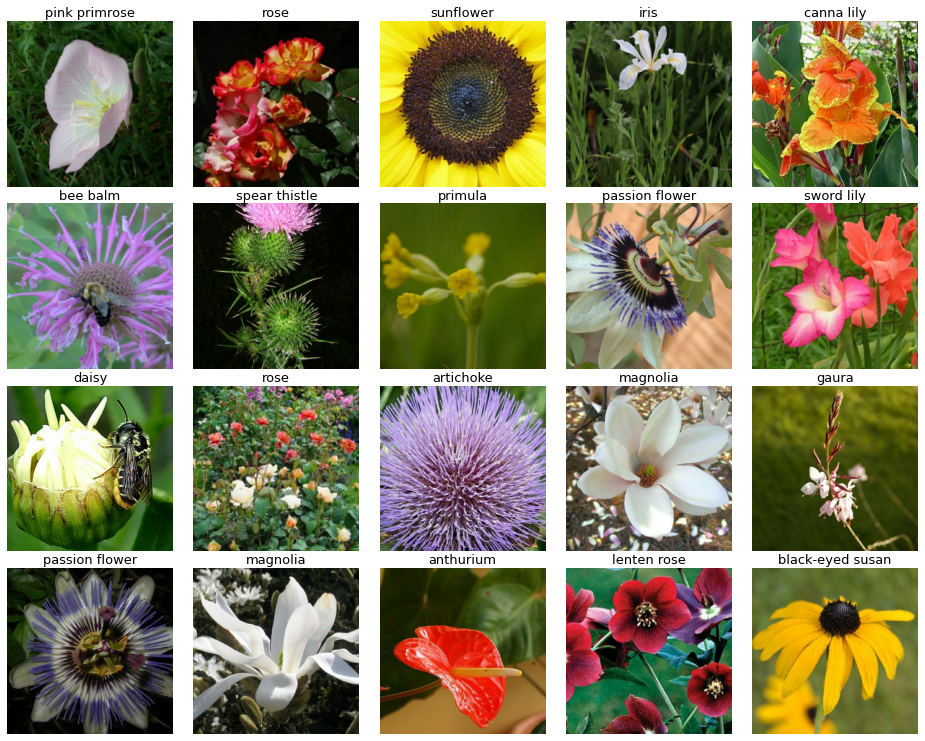

In [10]:
# Peek at training data
training_dataset = get_training_dataset()
trn_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(trn_dataset)
display_batch_of_images(next(train_batch))

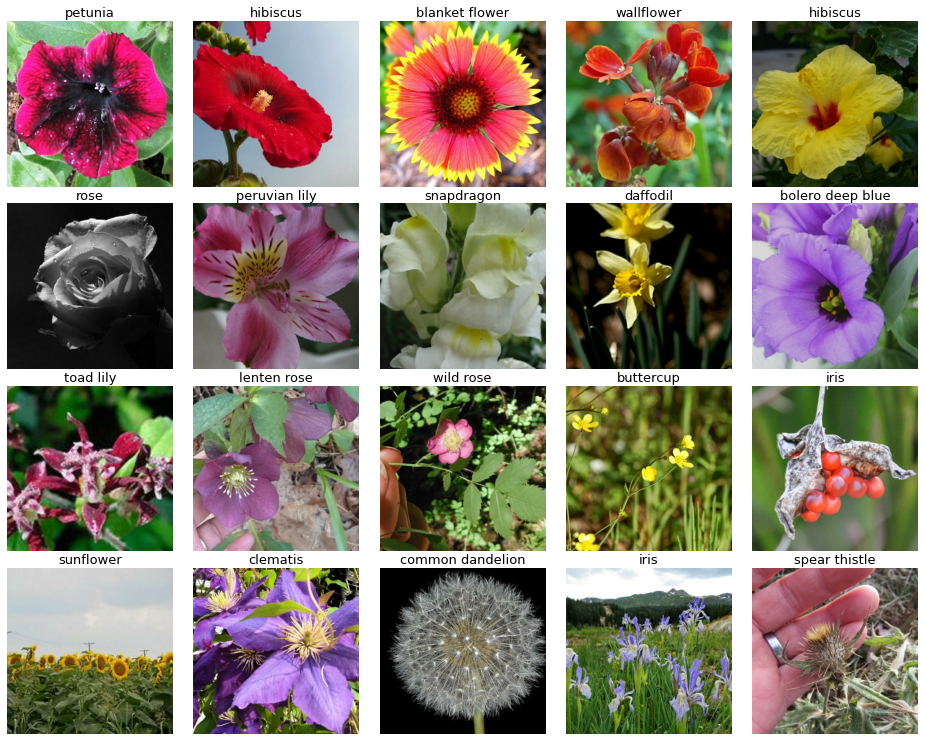

In [11]:
# Peek at Validation data
validation_dataset = get_validation_dataset()
val_dataset = validation_dataset.unbatch().batch(20)
val_batch = iter(val_dataset)
display_batch_of_images(next(val_batch))

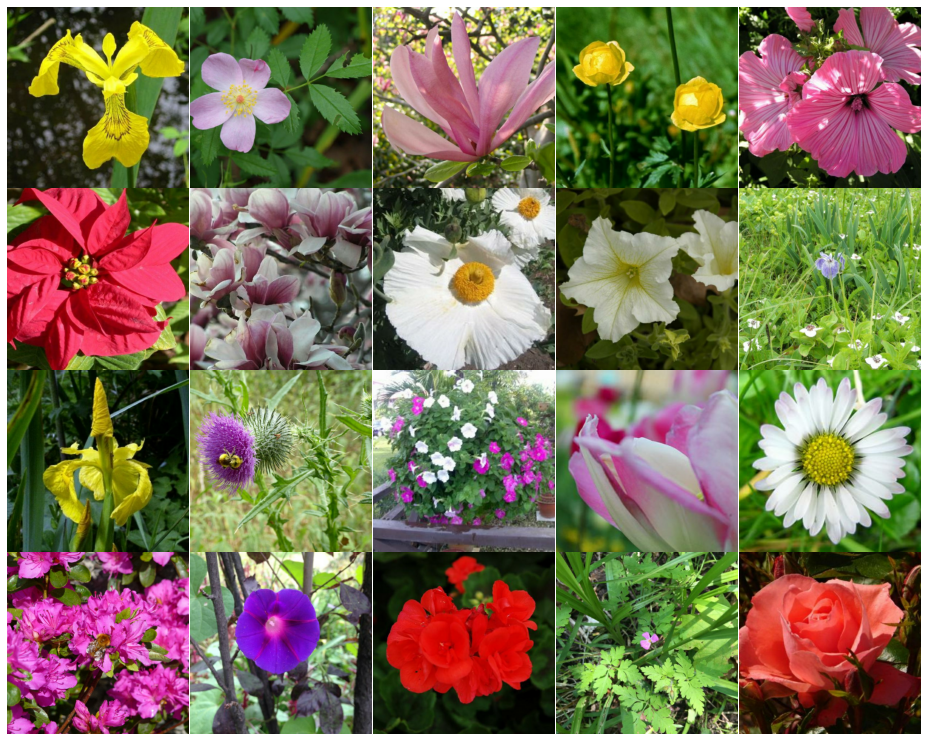

In [12]:
# Peek at Test data
test_dataset = get_test_dataset()
tst_dataset = test_dataset.unbatch().batch(20)
tst_batch = iter(tst_dataset)
display_batch_of_images(next(tst_batch))

# Hyper-Parameters
## Data Augmentation

The performance of deep learning neural networks often improves with the amount of data available. Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.


![Data augmentation](https://nanonets.com/blog/content/images/2018/11/1_dJNlEc7yf93K4pjRJL55PA--1-.png)

Some of the popular Image Augmentation techniques are :
1. Flip
2. Rotation
3. Scale
4. Crop
5. Translation
6. Adding Gaussian Noise 

For this project we have used flip and rotation and have done analysis in below sections.

## Transfer Learning

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

For this project, we used a deep learning model pre-trained for a large and challenging image classification task such as the ImageNet 1000-class photograph classification competition. As without the pretrained weights, These models can take days or weeks to train on modern hardware.

## Learning Rate Schedule

Adapting the learning rate for SGD optimization procedure can increase performance and reduce training time. this is called as Learning rate schedule or adaptive learning rates. The simplest and perhaps most used adaptation of learning rate during training are techniques that reduce the learning rate over time. These have the benefit of making large changes at the beginning of the training procedure when larger learning rate values are used, and decreasing the learning rate such that a smaller rate and therefore smaller training updates are made to weights later in the training procedure.

This has the effect of quickly learning good weights early and fine tuning them later.

Two popular and easy to use learning rate schedules are as follows:

- Decrease the learning rate gradually based on the epoch.
- Decrease the learning rate using punctuated large drops at specific epochs.

Learning rate schedule: 1e-05 to 0.0004 to 2.72e-05


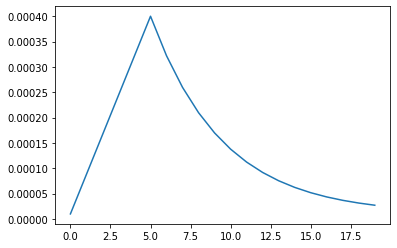

In [13]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))


# Modelling

To tackle this classification problem we have used various versions of Convolutional Neural Networks(CNNS) namely Resnet, DenseNet, EfficientNet. we will discuss briefly about each model in coming sections.

![CNNs for Classification](https://qph.fs.quoracdn.net/main-qimg-c05ec72225e19614f0cc10385d27525c)

## ResNet

In Standard ConvNet, input image goes through multiple convolution and obtain high-level features.

![Standard ConvNet](https://miro.medium.com/max/1400/1*RfyAoe6Wlv4aLip2Y5Aw-Q.png)
                    Figure : Standard Convolution Neural network

In ResNet, identity mapping is proposed to promote the gradient propagation. Element-wise addition is used. It can be viewed as algorithms with a state passed from one ResNet module to another one.

![Resnet Concept](https://miro.medium.com/max/1400/1*4wx7szWCBse9-7eemGQJSw.png)
                    Figure : ResNet Concept
                    
without pre Trained weights below is the performance of the model

![No_PreTrained_weights](https://www.kaggleusercontent.com/kf/32955340/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..8d51lY16icVhtKju-lxTCg.bGSqwSbUfoXI0va6ZXnowYKho5WGomp4oRDdOkP7LNIpbiplv_BCtcBBItHX7XZJP07nQq1--Yd1Eboo_g_e3gnAX9jqgnkGIMubyU7V40sRVBUinCQNBQJ340KPZB8sRejfOHtpnP1cqEmm3Xibm7mbX6OQ6izw7U9CrHJTRDZDw6ce6m5BFrWTIpaCtUkZ5BmvNojk2jPqXjF443wOjqqa1M2nDkI8zmXyUab7SdwrP9eDrt45OC5svQyvlpjMCUY0BXoajVjx8jmA8ThBA_SibT-vXge6qQBQzLjgKCD29W1hMntwM2D70DqqoHpUdSZWL7eWBQ8_8dL369wH8qoLoA92-u0iwkVSZcpSAQQzBbp_kUsskMfYsOMFKbAI_4dtqQkclI3iMfjDSRPl5tUI0h_Kzalr4ZRIhuNuN6rXzi0_AiWi9Udjn8V7j3Usuf_qX6Tn9ZeauQTDvGH7cGA3VXaD7tUw18PBpHLyFrSWAcKOhekYbj2kx3pyD65btLOiCdDyZjiMvEJRcXOFNWZDUbQC06zYcgmcNRAUj4TNy3Sf_YeFcYWIv6TJCJ9KkRZB6i5bcKuU-ENyqofqa0tY_MSeJPiwaqjcqqrS0S_LJGL0hDGVCm48kBQc83Onlgdf21OV35WyLAvxfBnKiml_u42603VNBJMCfTUK_kM.kVjqA5VBJzD-ysKI2Bu67A/__results___files/__results___27_1.png)


## DenseNet

In DenseNet, each layer obtains additional inputs from all preceding layers and passes on its own feature-maps to all subsequent layers. Concatenation is used. Each layer is receiving a “collective knowledge” from all preceding layers.

![DenseNet Working](https://miro.medium.com/max/1216/1*P7tcHlzxm9Afg0Cejftv0g.png)

Since each layer receives feature maps from all preceding layers, network can be thinner and compact, i.e. number of channels can be fewer. The growth rate k is the additional number of channels for each layer.

So, it have higher computational efficiency and memory efficiency. The following figure shows the concept of concatenation during forward propagation:

![Forward Propagation In DenseNet](https://miro.medium.com/max/1200/1*9ysRPSExk0KvXR0AhNnlAA.gif)

Figure : Forward Propagation in DenseBlock

![DenseNet Architecture](https://miro.medium.com/max/1200/1*IwvJGTxBAcb1H5tSJR6Lng.gif)


**Hyper-parameters**


**Evaluation**
![LossandAccuracy_densenet201](https://www.kaggleusercontent.com/kf/32976401/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..3Q7OER_dG7KepX6PmxMqZQ.oArduhvAp56buMBKO_KH4gFbK7KJ9Dn2VHpenCVCMzMr-Ns_Q-X_eS0c3yKDwlsKPU2RhognbioBwV7-7A0tkX6VWlNH1NaPzrQK-LHw8C0AvnaIQ4yGWciFuisCJ3MPovpG9uk_jTDkqbXk7DyOfznWZpy9xrdj_BeIUXqTTuOz_3pUTvX8Yr32IppHvI7n9SAvhJHuG2FD3i9wZFVjSMxoOM5snpZmQW8RkvdqiHKEVu4q89RgTR-sB793OVCgXpZnHEvMNxRYBVELu_iWxSGTTqIH27q-3K0ecbsC0eK7JMIZRwqAPLBN4FljZRjR95SuTy-DMvjVGOH-Ope__CAJRMGBabJ17QfKD5TW8O4LBGWqwcqI5mopE8EfCh3eATekq35ijYzyd9XUs0vaPJVCD271PYj3Uk_qJ88rC6Gay_k4Q8PeRztP8RB2mvd2oEjiicwWI72SWI40SpagCdJdvS757JgrrUNGQcPPAn2HqDSLnyIfuvnrjYC5ix3iBP0ZI6PLhaNb4slya3NvHEFGZBnZcFByRXz3qetbIq3CSIXLhIgCE5XJ5eyatdeiPl8rE32RY1E7wb3Vm3_o6ddhHBugxW76MMXKMknH-K81ioQW7VY-lfFWaJVxNjQu3mAq2W1nxkvkO4cyppKuHqKKXQEHpKO69oEetlTespOzhZIKCyzJ3YcOuA6Gsl5P.oVlOXIwrj8DnprR9khRWww/__results___files/__results___35_0.png)

In [14]:
%%time

from tensorflow.keras.applications import DenseNet201

with strategy.scope():
    rnet = DenseNet201(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        weights='imagenet',
        include_top=False
    )
rnet.trainable = True

model = tf.keras.Sequential([
        rnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________
CPU times: user 50 s, sys: 9.45 s, total: 59.5 s
Wall time: 1min 3s



## EfficientNet

Most of people in this competition has used Efficient Net for this competiton. we were curious about what's Efficient and why everyone is getting good scores with this new Image architecture.

This paper discusses efficient way of scaling a Convolutional Neural Network efficiently. CNN’s must be scaled up in multiple dimensions. Scaling CNN’s only in one direction (eg depth only) will result in rapidly deteriorating gains relative to the computational increase needed.Most CNN’s are typically scaled up by adding more layers or deeper . e.g. ResNet18, ResNet34, ResNet152, etc. The numbers represent the total number of blocks (layers) and in general, the more layers the more ‘power’ the CNN has. Going wider is another often used scaling method, and tends to capture finer details and can be easier to train. However, it’s benefits quickly saturate as well.

There are three scaling dimensions of a CNN: depth, width, and resolution. Depth simply means how deep the networks is which is equivalent to the number of layers in it. Width simply means how wide the network is. One measure of width, for example, is the number of channels in a Conv layer whereas Resolution is simply the image resolution that is being passed to a CNN. The figure below(from the paper itself) will give you a clear idea of what scaling means across different dimensions.

![Scaling_CNN](https://miro.medium.com/max/1400/1*xQCVt1tFWe7XNWVEmC6hGQ.png)



![LossandAccuracy_EfficiencyNet201](https://www.kaggleusercontent.com/kf/32976401/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..3Q7OER_dG7KepX6PmxMqZQ.oArduhvAp56buMBKO_KH4gFbK7KJ9Dn2VHpenCVCMzMr-Ns_Q-X_eS0c3yKDwlsKPU2RhognbioBwV7-7A0tkX6VWlNH1NaPzrQK-LHw8C0AvnaIQ4yGWciFuisCJ3MPovpG9uk_jTDkqbXk7DyOfznWZpy9xrdj_BeIUXqTTuOz_3pUTvX8Yr32IppHvI7n9SAvhJHuG2FD3i9wZFVjSMxoOM5snpZmQW8RkvdqiHKEVu4q89RgTR-sB793OVCgXpZnHEvMNxRYBVELu_iWxSGTTqIH27q-3K0ecbsC0eK7JMIZRwqAPLBN4FljZRjR95SuTy-DMvjVGOH-Ope__CAJRMGBabJ17QfKD5TW8O4LBGWqwcqI5mopE8EfCh3eATekq35ijYzyd9XUs0vaPJVCD271PYj3Uk_qJ88rC6Gay_k4Q8PeRztP8RB2mvd2oEjiicwWI72SWI40SpagCdJdvS757JgrrUNGQcPPAn2HqDSLnyIfuvnrjYC5ix3iBP0ZI6PLhaNb4slya3NvHEFGZBnZcFByRXz3qetbIq3CSIXLhIgCE5XJ5eyatdeiPl8rE32RY1E7wb3Vm3_o6ddhHBugxW76MMXKMknH-K81ioQW7VY-lfFWaJVxNjQu3mAq2W1nxkvkO4cyppKuHqKKXQEHpKO69oEetlTespOzhZIKCyzJ3YcOuA6Gsl5P.oVlOXIwrj8DnprR9khRWww/__results___files/__results___30_0.png)

In [15]:
%%time
import efficientnet.tfkeras as efn

# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
with strategy.scope():
    enet = efn.EfficientNetB7(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        weights='imagenet',
        include_top=False
    )
    
    enet.trainable = True

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
            
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

258441216/258434480 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________
CPU times: user 1min 1s, sys: 11.6 s, total: 1min 13s
Wall time: 1min 25s


# Ensemble

Taking Average of Efficiency Net and Dense Net. we plot a confusion matrix along with accuracy and F1 Score.

![Confusion_Matrix](https://www.kaggleusercontent.com/kf/32976401/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..3Q7OER_dG7KepX6PmxMqZQ.oArduhvAp56buMBKO_KH4gFbK7KJ9Dn2VHpenCVCMzMr-Ns_Q-X_eS0c3yKDwlsKPU2RhognbioBwV7-7A0tkX6VWlNH1NaPzrQK-LHw8C0AvnaIQ4yGWciFuisCJ3MPovpG9uk_jTDkqbXk7DyOfznWZpy9xrdj_BeIUXqTTuOz_3pUTvX8Yr32IppHvI7n9SAvhJHuG2FD3i9wZFVjSMxoOM5snpZmQW8RkvdqiHKEVu4q89RgTR-sB793OVCgXpZnHEvMNxRYBVELu_iWxSGTTqIH27q-3K0ecbsC0eK7JMIZRwqAPLBN4FljZRjR95SuTy-DMvjVGOH-Ope__CAJRMGBabJ17QfKD5TW8O4LBGWqwcqI5mopE8EfCh3eATekq35ijYzyd9XUs0vaPJVCD271PYj3Uk_qJ88rC6Gay_k4Q8PeRztP8RB2mvd2oEjiicwWI72SWI40SpagCdJdvS757JgrrUNGQcPPAn2HqDSLnyIfuvnrjYC5ix3iBP0ZI6PLhaNb4slya3NvHEFGZBnZcFByRXz3qetbIq3CSIXLhIgCE5XJ5eyatdeiPl8rE32RY1E7wb3Vm3_o6ddhHBugxW76MMXKMknH-K81ioQW7VY-lfFWaJVxNjQu3mAq2W1nxkvkO4cyppKuHqKKXQEHpKO69oEetlTespOzhZIKCyzJ3YcOuA6Gsl5P.oVlOXIwrj8DnprR9khRWww/__results___files/__results___38_0.png)

Table for Kaggle Scores

| Model  | Score  | Rank  |
|---|---|---|
| Native ResNet  | 0.60568  | 670  |
| DenseNet201  | 0.95085 | 457 |
| EfficientNet  | 0.95702 | 372 |
| Ensemble(Efficient + Dense)  | 0.96064  | 322 |

# References
1. Data Augmentation using Keras, https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

2. Data Augmentation in deep Learning, https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/ 

3. Transfer Learning Intro, https://machinelearningmastery.com/transfer-learning-for-deep-learning/

4. Transfer Learning in practice, https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

5. Resnet Review, https://towardsdatascience.com/review-resnet-winner-of-ilsvrc-2015-image-classification-localization-detection-e39402bfa5d8

6. DenseNet Review, https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803

7. EfficientNet Review, https://medium.com/@nainaakash012/efficientnet-rethinking-model-scaling-for-convolutional-neural-networks-92941c5bfb95

8. EfficientNet by Google, https://towardsdatascience.com/googles-efficientdet-an-overview-8d010fa15860

